# Fashion MNIST CNN

In [14]:
# baseline cnn model for fashion mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

import sys

In [2]:
device_name = "/gpu:0"

In [3]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [4]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [5]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=3):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

In [8]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

In [9]:
# run the test harness for evaluating a model
def run_test_harness():
    with tf.device(device_name): 
        # load dataset
        trainX, trainY, testX, testY = load_dataset()
        # prepare pixel data
        trainX, testX = prep_pixels(trainX, testX)
        # evaluate model
        scores, histories = evaluate_model(trainX, trainY)
        # learning curves

        summarize_diagnostics(histories)
        # summarize estimated performance
        summarize_performance(scores)
 

> 90.885
> 90.530
> 89.840


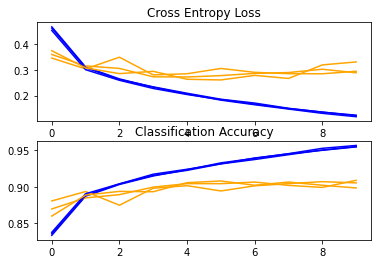

Accuracy: mean=90.418 std=0.434, n=3


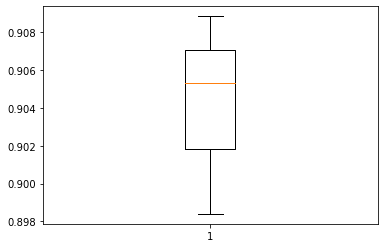

In [10]:
# entry point, run the test harness
run_test_harness()

## Test manually

In [11]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)

In [12]:
with tf.device(device_name):
    model = define_model()
    # fit model
    callback = tf.keras.callbacks.EarlyStopping(patience=3)
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split = 0.2, verbose=1, callbacks=[callback])
    _, acc = model.evaluate(testX, testY, verbose=0)
    print(acc)

Epoch 1/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.5866 - accuracy: 0.7907 - val_loss: 0.3761 - val_accuracy: 0.8583
Epoch 2/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2918 - accuracy: 0.8937 - val_loss: 0.2854 - val_accuracy: 0.8996
Epoch 3/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2464 - accuracy: 0.9090 - val_loss: 0.2753 - val_accuracy: 0.9009
Epoch 4/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2140 - accuracy: 0.9212 - val_loss: 0.2532 - val_accuracy: 0.9083
Epoch 5/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1905 - accuracy: 0.9307 - val_loss: 0.2635 - val_accuracy: 0.9072
Epoch 6/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1638 - accuracy: 0.9383 - val_loss: 0.2702 - val_accuracy: 0.9065
Epoch 7/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1446 - accuracy: 0.9477 - val_loss: 0.2773 - val_accur

In [13]:
print(acc)

0.9041000008583069


## Create define_model function with adjustable hyperparameters input

In [41]:
"""
The target is to maximize the accuracy of the cnn-mnist model:
    We start by having a few decisions related to the model. 
    x1 = 32 or 64 (or 128) filters in each CNN layer
    x2 = 50 or 100 neurons in first dense layer
    x3 = 1 or 2 CNN layers
    x4 = he_uniform or random_normal
    x5 = no dropout, (0.1 dropout,) 0.2 dropout
    x6 = learning rate 0.005, (0.01) or 0.05 
    x7 = kernel size cnn 2, 3
    We will use a genetic algorithm to find the best combinations of these hyperparameters. 
    The fitness-function is based on model accuracy on test-dataset. 
"""

def define_model_ga(hyperparameter_arr):
    neurons_cnn = [32, 64][hyperparameter_arr[0]]
    neurons_first = [50, 100][hyperparameter_arr[1]]
    cnn_layers = [1, 2][hyperparameter_arr[2]]
    initializer = ['he_uniform', 'random_normal'][hyperparameter_arr[3]]
    dropout = [False, 0.2][hyperparameter_arr[4]]
    learning_rate = [0.005, 0.05][hyperparameter_arr[5]]
    kernel_size_cnn = [2, 3][hyperparameter_arr[6]]
    
    model = Sequential()
    for i in range(cnn_layers): 
        model.add(Conv2D(neurons_cnn, (kernel_size_cnn, kernel_size_cnn), activation='relu', kernel_initializer=initializer, input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
    if (dropout): 
        model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(neurons_first, activation='relu', kernel_initializer=initializer))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=learning_rate, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Test one round of fitting with ga model definition

In [42]:
# load dataset
dataX, dataY, data_testX, data_testY = load_dataset()
# prepare pixel data
dataX, dataX = prep_pixels(dataX, dataX)

In [47]:
with tf.device(device_name):
    arr = [1, 1, 0, 1, 0, 0, 0, 0]
    # define kfold
    scores, histories = list(), list()
    # prepare cross validation
    n_folds = 5
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model_ga(arr)
        callback = tf.keras.callbacks.EarlyStopping(patience=3)
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=20, batch_size=32, validation_split = 0.2, verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)

Epoch 1/10
1200/1200 [==============================] - 10s 8ms/step - loss: 0.8929 - accuracy: 0.6844 - val_loss: 0.4704 - val_accuracy: 0.8324
Epoch 2/10
1200/1200 [==============================] - 10s 8ms/step - loss: 0.4437 - accuracy: 0.8389 - val_loss: 0.3905 - val_accuracy: 0.8603
Epoch 3/10
1200/1200 [==============================] - 10s 8ms/step - loss: 0.3929 - accuracy: 0.8553 - val_loss: 0.3697 - val_accuracy: 0.8684
Epoch 4/10
1200/1200 [==============================] - 10s 8ms/step - loss: 0.3422 - accuracy: 0.8794 - val_loss: 0.3541 - val_accuracy: 0.8696
Epoch 5/10
1200/1200 [==============================] - 10s 8ms/step - loss: 0.3161 - accuracy: 0.8859 - val_loss: 0.3376 - val_accuracy: 0.8745
Epoch 6/10
1200/1200 [==============================] - 10s 8ms/step - loss: 0.2952 - accuracy: 0.8916 - val_loss: 0.3266 - val_accuracy: 0.8816
Epoch 7/10
1200/1200 [==============================] - 10s 8ms/step - loss: 0.2760 - accuracy: 0.8987 - val_loss: 0.3091 - val_ac

In [46]:
mean(scores)

0.8919166723887125